<h1><center><h1>Algorithme de Machine Learning</h1></center>
    
<center>Réseau Neuronal Artificiel</center></h1>

<h2><b>I. Description du module <span style="color:blue">NeuralNetWork</span></b></h2>

<p>On définit dans un premier temps les fonctions <b><i>Sigmoid</i></b> et <b><i>SigPrime</i></b> représentant respectivement la fonction d'activation du réseau et sa dérivée (utile pour la correction, en réalité la dérivée de la sigmoïde est SigPrime(Sigmoid(x)) mais l'utilisation de SigPrime en l'état éclaircit le code). On définit ensuite 4 classes : <b><i>Brain</i></b>, <b><i>Layer</i></b>, <b><i>InputLayer</i></b> et <b><i>OutputLayer</i></b>.</p>
<p>La classe <b><i>Brain</i></b> comme son nom l'indique est représentative du Cerveau entier, regroupant tous les couches de neurones. Dans cette classe on orchestre la communication 'synaptique', soit la communication entre couches. C'est la seule classe directement instanciée par l'utilisateur, puisque les autres sont instanciées à la création de celle-ci.</p>
<p>La classe <b><i>Layer</i></b> représente une couche de neurones, avec un grand nombre de méthodes permettant la communication avec les autres couches. Les classes <b><i>InputLayer</i></b> et <b><i>OutputLayer</i></b> ne sont que des cas particuliers de couches de neurones (l'entrée et la sortie). </p>
<p>On utilisera les modules <i>Numpy</i> et <i>Matplotlib</i> pour la représentation</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#========================== Fonctions 

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigPrime(x):
    return x*(1-x)


<h4>1. Classe <b>Brain</b></h4>
<p>À l'initialisation on ne demande que le nombre de neurones en entrée, en sortie, et dans les couches cachées (on considère que toutes les couches cachées ont le même nombre de neurones pour faciliter la prise en main) et enfin le nombre de couches cachées. La classe ne possède que deux méthodes utilisées par l'utilisateur : <b>train</b> et <b>test</b>. La méthode <b>train</b> permet l'entrainement du réseau neuronal avec les données <i>data</i> (cela sera plus détaillé dans la partie des tests. La méthode <b>test</b> permet simplement, une fois le cerveau entrainé, d'avoir la réponse à une entrée donnée.</p>
<p>Ci-dessous les codes de toutes les classes.</p>

In [3]:

class Brain:
    def __init__(self,nb_neurons_input,nb_neurons_hidden,nb_neurons_output,nb_hidden):
        self.__layers = [InputLayer(nb_neurons_input)]
        self.__layers.append(Layer(nb_neurons_hidden,nb_neurons_input))
        for x in range(nb_hidden-1):
            self.__layers.append(Layer(nb_neurons_hidden,nb_neurons_hidden))
        self.__layers.append(OutputLayer(nb_neurons_output,nb_neurons_hidden))
        
        self.__train_data = None
        self.__train_solution = None
        return
    
    def set_train_data(self,data):
        self.__train_data = data
        return
    
    def set_train_solution(self,solution):
        self.__train_solution = solution
        return
    
    def run_all(self,entry):
        '''
        Permet un passage dans le réseau neuronal. 
        (Un 'ALLER' avec comme entrée la variable entry {FEEDFORWARD})
        '''
        self.__layers[0].set_entry(entry)
        self.__layers[1].set_A_Nminus1(entry)
        for i in range(1,len(self.__layers)):
            self.__layers[i].run()
            if i+1!=len(self.__layers):
                self.__layers[i+1].set_A_Nminus1(self.__layers[i].get_A_N())
        return
    
    def correct_all(self,cost=False,coeff=1):
        '''
        Correction de tous les coefficients du réseau
        (passage 'RETOUR' et correction par calcul du gradient {BACKPROPAGATION})
        '''
        L_N = self.__layers[-1]
        L_Nminus1 = self.__layers[-2]
        L_N.set_exact(self.__train_solution)
        L_N.correct(coeff)
        L_Nminus1.set_W_N(L_N.get_W_Nminus1())
        L_Nminus1.set_Err_N(L_N.get_Err_Nminus1())
        for i in range(2,len(self.__layers)):
            L_N = self.__layers[-i]
            L_Nminus1 = self.__layers[-i-1]
            L_N.correct(coeff)
            L_Nminus1.set_W_N(L_N.get_W_Nminus1())
            L_Nminus1.set_Err_N(L_N.get_Err_Nminus1())
        if cost:
            return self.__layers[-1].cost()
        return
    
    def train(self,Data,Solution,Iter_Training,Cost_Rate=10,Coeff=1):
        '''
        Entrainement du réseau avec les variables Data et Solution
        On effectue un nombre d'iteration de l'entrainement : Iter_Training 
        
        Cost_Rate (default=10) le 'pas' du tracé de la courbe du cout en fonction du nb d'iterations
        '''
        self.set_train_data(Data)
        self.set_train_solution(Solution)
        Iter = []
        Cost = []
        I10 = Iter_Training//10
        for i in range(Iter_Training):
            if i%I10==0:
                c = i//I10
                c = 10*c
                print('Running ... {}%'.format(c))
            self.run_all(self.__train_data)
            if Iter_Training%Cost_Rate==0:
                a = self.correct_all(True,Coeff)
#                print('Training Iter N° :',i, 'Cost :',a)
                Iter.append(i)
                Cost.append(a)
            else:
                self.correct_all(coeff=Coeff)
        plt.plot(Iter,Cost)
        plt.show()
        return
    
    def test(self,entry):
        '''
        Méthode pour simplemennt faire traverser le réseau à la variable entry
        À utiliser une fois que le réseau est entrainé
        '''
        self.run_all(entry)
        out = self.__layers[-1].get_A_N()
        print('===========OutPut==========')
        print(out)
        return out

<h4>2. Classes <b>Layer</b></h4>
<p> 

In [4]:
class Layer:
    def __init__(self,nb_neurons, nb_neurons_Nminus1):
        self.__nb_neurons = nb_neurons
        
        #N-1
        self.__A_Nminus1 = None
        self.__W_Nminus1 = 2*np.random.random((nb_neurons,nb_neurons_Nminus1)) - 1
        self.__B_Nminus1 = 2*np.random.random((nb_neurons,1)) - 1
        self.__Err_Nminus1 = None
        #N
        self.__A_N = np.zeros((nb_neurons,1))
        self.__W_N = None
        self.__Err_N = None
        
        return
    
    
    
    def get_A_N(self): 
        return self.__A_N
    
    def get_Err_Nminus1(self):
        return self.__Err_Nminus1
    
    def get_W_Nminus1(self):
        return self.__W_Nminus1
    
    def set_W_N(self,W):
        self.__W_N = W
        return
    def set_Err_N(self,E):
        self.__Err_N = E
        return
    
    def set_A_Nminus1(self,A):
        self.__A_Nminus1 = A
        return
    
    #Les méthodes précédentes sont nécéssaires pour la communication synaptique entre couches
    
    def do_Err_Nminus1(self):
        self.__Err_Nminus1 = sigPrime(self.__A_N)*(np.dot(self.__W_N.T,self.__Err_N))
        return
    
    #la variable Err est une variable pivot pour eclaircir les calculs
    
    def run(self):
        '''
        Passage dans la couche (FEEDFORWARD)
        '''
        self.__A_N = sigmoid(np.dot(self.__W_Nminus1,self.__A_Nminus1) + self.__B_Nminus1)
        return
    
    def correct(self,coeff=1): 
        '''
        Correction des coefficiens de W_Nminus1 et B_Nminus1 
        '''
        if coeff!=1:
            print('ok')
        self.do_Err_Nminus1()
        (a,b) = np.shape(self.__Err_Nminus1)
        
        corr_W_Nminus1 = coeff*np.dot(self.__Err_Nminus1,self.__A_Nminus1.T)
        corr_B_Nminus1 = coeff*np.dot(self.__Err_Nminus1,np.ones((b,1)))
        
        sign = -1
        
        self.__W_Nminus1 += sign*corr_W_Nminus1
        self.__B_Nminus1 += sign*corr_B_Nminus1
        
        return

In [5]:
class InputLayer(Layer):
    def __init__(self,nb_neurons):
        self.__neurons = None
        self.__nb_neurons = nb_neurons
        return
    
    def set_entry(self,L):
        self.__neurons = L
        return 
    
    def run(self):
        print("Can't run entry")
        return
    
    def correct(self):
        print("Can't correct entry")
        return 

In [6]:
class OutputLayer:
    def __init__(self,nb_neurons, nb_neurons_Nminus1):
        self.__nb_neurons = nb_neurons
        
        #N-1
        self.__A_Nminus1 = None
        self.__W_Nminus1 = 2*np.random.random((nb_neurons,nb_neurons_Nminus1)) - 1
        self.__B_Nminus1 = 2*np.random.random((nb_neurons,1)) - 1
        self.__Err_Nminus1 = None
        #N
        self.__A_N = np.zeros((nb_neurons,1))
        self.__W_N = None
        self.__Err_N = None
        
        self.__exact = None
        return

    
    def set_exact(self,L):
        self.__exact = L
        return

    def cost(self):
        c = sum((self.__A_N - self.__exact)**2)
        p = len(c)
        return sum(c)/p
    
    def do_Err_Nminus1(self):
        self.__Err_N = 2*(self.__A_N - self.__exact)
        self.__Err_Nminus1 = sigPrime(self.__A_N)*self.__Err_N
        return

    def get_A_N(self): 
        return self.__A_N
    
    def get_Err_Nminus1(self):
        return self.__Err_Nminus1
    
    def get_W_Nminus1(self):
        return self.__W_Nminus1
    
    def set_W_N(self,W):
        self.__W_N = W
        return
    def set_Err_N(self,E):
        self.__Err_N = E
        return
    
    def set_A_Nminus1(self,A):
        self.__A_Nminus1 = A
        return
    
    def run(self):
        self.__A_N = sigmoid(np.dot(self.__W_Nminus1,self.__A_Nminus1) + self.__B_Nminus1)
        return
    
    def correct(self,coeff=1): 
        self.do_Err_Nminus1()
        (a,b) = np.shape(self.__Err_Nminus1)
        
        corr_W_Nminus1 = coeff*np.dot(self.__Err_Nminus1,self.__A_Nminus1.T)
        corr_B_Nminus1 = coeff*np.dot(self.__Err_Nminus1,np.ones((b,1)))
        
        sign = -1
        
        self.__W_Nminus1 += sign*corr_W_Nminus1
        self.__B_Nminus1 += sign*corr_B_Nminus1
        
        return

<b></b>

<h2>II. Exemple d'utilisation du module</h2>


Le module peut être utilisé pour identifier une séquence répétitive dans un jeu de données, comme une forme : ce type d'algorithme est souvent utilisé pour identifier une lettre ou un chiffre manuscrit. 

L'application possible au PE est que l'algorithme pourrait apprendre à reconnaître un coup, en fonction soit de son "tracé" en 3D soit de ses projections sur les différents plans. Une autre approche serait d'identifier un coup en fonction de ses paramètres caractéristiques (comme le rayon de courbure, la vitesse moyenne, la vitesse avant et après rebond, etc...).



<h4>1. Exemple simple</h4>

Ci-dessous un exemple très simple d'utilisation : on utilise un réseau 4 entrées 1 sortie et on identifie quand la séquence en entrée contient deux "1 au milieu" (comme ici [0,1,1,0] ou [1,1,1,0]) ou du moins se raproche de cette structure. 
En effet, l'avantage de cet algorithme est que, toutes les valeurs étant réelles entre 0 et 1, la sortie (unique dans ce cas) représente un taux de fiabilité, qui ne vaut donc jamais rigoureusement 1...

Running ... 0%
Running ... 10%
Running ... 20%
Running ... 30%
Running ... 40%
Running ... 50%
Running ... 60%
Running ... 70%
Running ... 80%
Running ... 90%


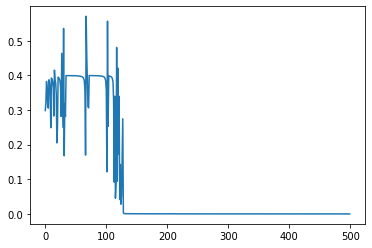

===========OutPut==========
[[0.99292803 0.99482973 0.00355931 0.0012171 ]]
[[1 1 0 0]]


In [7]:
inputs = np.array([[0   , 0   , 0   , 1   ],
                   [0.2 , 0   , 0.9 , 1   ],
                   [0   , 1   , 1   , 0.75],
                   [0.76, 0.22, 0.97, 0   ],
                   [1   , 1   , 1   , 0.2 ]])

reponses = np.array([[0],
                     [0],
                     [1],
                     [0],
                     [1]])

inputs_test = np.array([[1  , 0.95, 1  , 0],
                        [0.2, 1   , 0.7, 0],
                        [0  , 0   , 1  , 0],
                        [1  , 0   , 0  , 0]])

reponses_test = np.array([[1],
                          [1],
                          [0],
                          [0]])

Alexa = Brain(4,16,1,2)
Alexa.train(inputs.T,reponses.T,500)

Alexa.test(inputs_test.T)
print(reponses_test.T)

On a une fiabilité très grande pour un entraînement très court (seulement 500 itérations d'entraînement). On a tracé le coût (i.e. l'erreur) en fonction du nombre d'iterations. 

<h2>Conclusion quant à l'application au PE</h2>

Bien que l'algorithme soit fonctionnel dans l'exemple plus haut, dès que l'on s'interesse à une identification plus poussée, la complexité de la phase d'<i>entraînement</i> devient trop importante et on observe des phénomènes de saturation de l'erreur relative à des valeurs bien trop élevées (au mieux 0.2)(Cela a été testé dans l'identification d'un caractère manuscrit (un x)). L'approche comme mentionée au-dessus, constistant à identifier la nature d'un coup via ses paramètres caractéristiques, pourrait répondre à ce problème bien que son fonctionnement reste purement théorique.